In [1]:
import os
import sys
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

%matplotlib inline

from gofem.parameter_handler import *
from gofem.mesh_utils import *
from gofem.data_utils import *

import PyDealII.Release as dealii

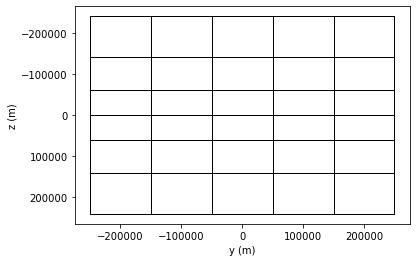

In [2]:
dy = np.ones(shape=5) * 1e5
dz = np.array([100, 80, 60, 60, 80, 100], dtype = np.float64) * 1000
mesh_size = np.array([np.sum(dy), np.sum(dz)])

p_origin = dealii.Point((-mesh_size / 2.).tolist())
p_end = dealii.Point((mesh_size / 2.).tolist())

triangulation = dealii.Triangulation('2D')
triangulation.generate_subdivided_steps_hyper_rectangle([dy.tolist(), dz.tolist()], p_origin, p_end, False)

fig, ax = plot_2d_triangulation(triangulation)

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f58c67cec90>)

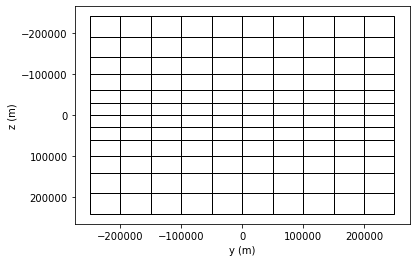

In [3]:
triangulation.refine_global(1)
plot_2d_triangulation(triangulation)

In [4]:
for cell in triangulation.active_cells():
    if cell.center().y < 0:
        cell.material_id = 1
    else:
        cell.material_id = 2

materials = {1: ('air', 1e-8), 2: ('ground', 0.01)}

# Switch to one if displacement currents are needed 
# (e.g., in case of RMT or GPR applications)
permittivity = 0.

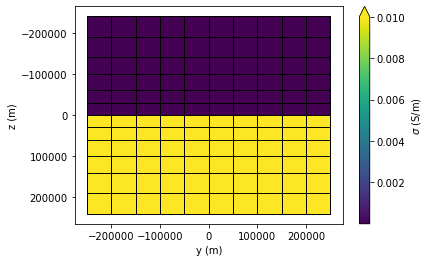

In [5]:
def color(cell):
    return materials[cell.material_id][1]

fig, ax = plot_2d_triangulation(triangulation, color_scheme=color)
fig.colorbar(ax.collections[0], ax=ax,\
             orientation = 'vertical',\
             label = r'$\sigma$ (S/m)',\
             norm=colors.LogNorm(vmin = 1e-8, vmax = 1e-2),\
             extend='max')

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f58c6697050>)

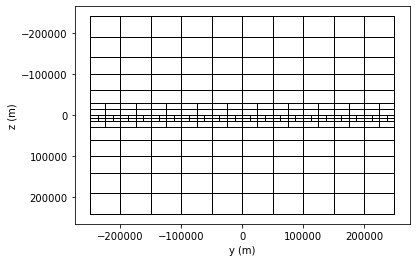

In [6]:
refine_at_interface(triangulation, material_ids = [2], repeat = 2)
plot_2d_triangulation(triangulation)

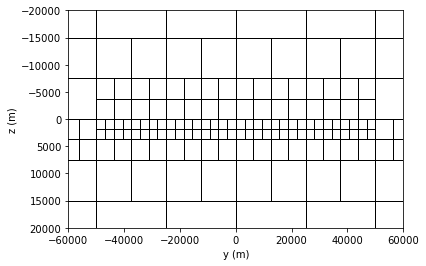

In [7]:
refine_at_interface(triangulation, material_ids = [2], repeat = 2, center = [0,0], radii = [50000])
fig, ax = plot_2d_triangulation(triangulation)
ax.set_xlim([-60000, 60000])
ax.set_ylim([-20000, 20000])
ax.invert_yaxis()

In [8]:
print('# of cells = %d\nsmallest cell = %0.1f m\nlargest cell = %0.1f m' % (triangulation.n_active_cells(),\
                                                                      triangulation.minimal_cell_diameter(),\
                                                                      triangulation.maximal_cell_diameter()))

# of cells = 360
smallest cell = 3644.3 m
largest cell = 70710.7 m


# of cells = 2904
smallest cell = 227.8 m
largest cell = 70710.7 m


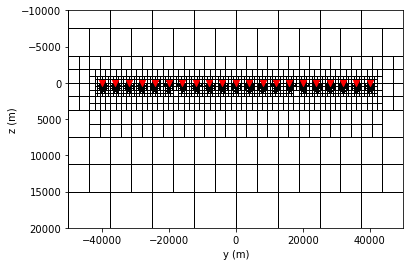

In [9]:
r_y = np.arange(-40000.1, 40000, 4000)
receivers = []
for y in r_y:
    receivers.append([y, 0.1])
    
refine_around_points(triangulation, points = receivers,\
                     center = [0, 0], radii = [2000, 2000],\
                     repeat = 2, exclude_materials = [1])

refine_around_points(triangulation, points = receivers,\
                     center = [0, 0], radii = [1000, 1000],\
                     repeat = 2, exclude_materials = [1])

fig, ax = plot_2d_triangulation(triangulation)
ax.set_xlim([-50000, 50000])
ax.set_ylim([-10000, 20000])
ax.invert_yaxis()
ax.scatter(r_y, r_y*0 + 0.1, color='r', marker='v')

print('# of cells = %d\nsmallest cell = %0.1f m\nlargest cell = %0.1f m' % (triangulation.n_active_cells(),\
                                                                      triangulation.minimal_cell_diameter(),\
                                                                      triangulation.maximal_cell_diameter()))

## Creating input files for GoFEM

Now, we can save the mesh, material properties and receivers in files that will be read by GoFEM:

In [10]:
# save the mesh
triangulation.save('./01/model.tria')

# save the material properties
with open('./01/model.materials', 'w') as f:
    f.write('# id name conductivity permitivitty\n')
    f.write('iso\n')
    for mid,properties in materials.items():
        f.write("%d %s %0.6e %0.6e\n" % (mid, properties[0], properties[1], permittivity))

# save receivers
with open('./01/receivers', 'w') as f:
    f.write('# type name number_of_points x y z\n')
    idx = 0
    for rec in receivers:
        f.write("Dipole R%d 1 0. %0.6e %0.6e\n" % (idx, rec[0], rec[1]))
        idx += 1
        
# save frequencies
frequencies = np.logspace(-2, 2, 33)
np.savetxt('./01/frequencies', frequencies, header = '# frequency (Hz)')

In case you work with CSEM, you have to also setup sources. Example below creates an inline unit current electric dipole source placed at (0,1):

In [11]:
with open('./01/sources', 'w') as f:
    f.write('# type name field n_parts x y z moment_x moment_y moment_z current_re current_im\n')
    f.write("Dipole S1 E 1 0. 0. 1. 0. 1. 0. 1. 0.\n")

Finally, we can create an input parameter file:

In [12]:
prm = ParameterHandler(inversion = False, dim = 2)

# Let's use quadratic elements for accuracy
prm.setitem(section = 'Modeling',\
            parameter = 'Order',\
            value = 2)

# Tell the code where to read all files from
prm.setitem(section = 'Model',\
            parameter = 'Model definition file',\
            value = '../model.tria')
prm.setitem(section = 'Model',\
            parameter = 'Materials definition file',\
            value = '../model.materials')

prm.setitem(section = 'Survey',\
            parameter = 'Frequencies file',
            value = '../frequencies')
prm.setitem(section = 'Survey',\
            parameter = 'Stations file',
            value = '../receivers')
prm.setitem(section = 'Survey',\
            parameter = 'Sources file',
            value = '../sources')

prm.setitem(section = 'Output',\
            parameter = 'Type',
            value = 'point')
prm.setitem(section = 'Output',\
            parameter = 'Data file',
            value = 'halfspace')

prm.write('./01/input_modeling.prm')

## Run the code

Since this is a simple 2-D problem, modeling will not take long and we can run it from here

In [14]:
import subprocess,shlex

f = open("output.txt", "w")
args = shlex.split("gofem --parameter_file ../input_modeling.prm --task modeling --dim 2 --method MT")
proc = subprocess.Popen(args, stdout=f, stderr=f, cwd = './01/results')
f.close()

## Reading and plotting results

Upon finishing, the GoFEM will output both the modelled fields at the receiver locations at all frequencies (and sources, for CSEM) as well as the VTU files with the model and its attributes (if this type of output is requested), such as conductivity, EM fields, etc. The former can be read using a pyGoFEM function, whereas the latter is a Paraview compatible format that you can visualize externally or, if you feel enthusiastic, you can also use the paraview from within the python. 

Below, we read the GoFEM modeling results at receivers by using the pandas:

In [15]:
dfs = read_modeling_output('./01/results/halfspace_c=0_f=%0.8e.txt', frequencies)

rho_data = np.zeros(shape=(len(frequencies),len(receivers),2))
phi_data = np.zeros(shape=(len(frequencies),len(receivers),2))
for idx in range(len(frequencies)):
    rho_data[idx] = dfs[idx][['rho_xy', 'rho_yx']]
    phi_data[idx] = dfs[idx][['phi_xy', 'phi_yx']]

/home/agrayver/anaconda3/envs/pygofem/lib/python3.7/site-packages/ipykernel_launcher.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  
/home/agrayver/anaconda3/envs/pygofem/lib/python3.7/site-packages/ipykernel_launcher.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  import sys


And finally plot TE and TM modes

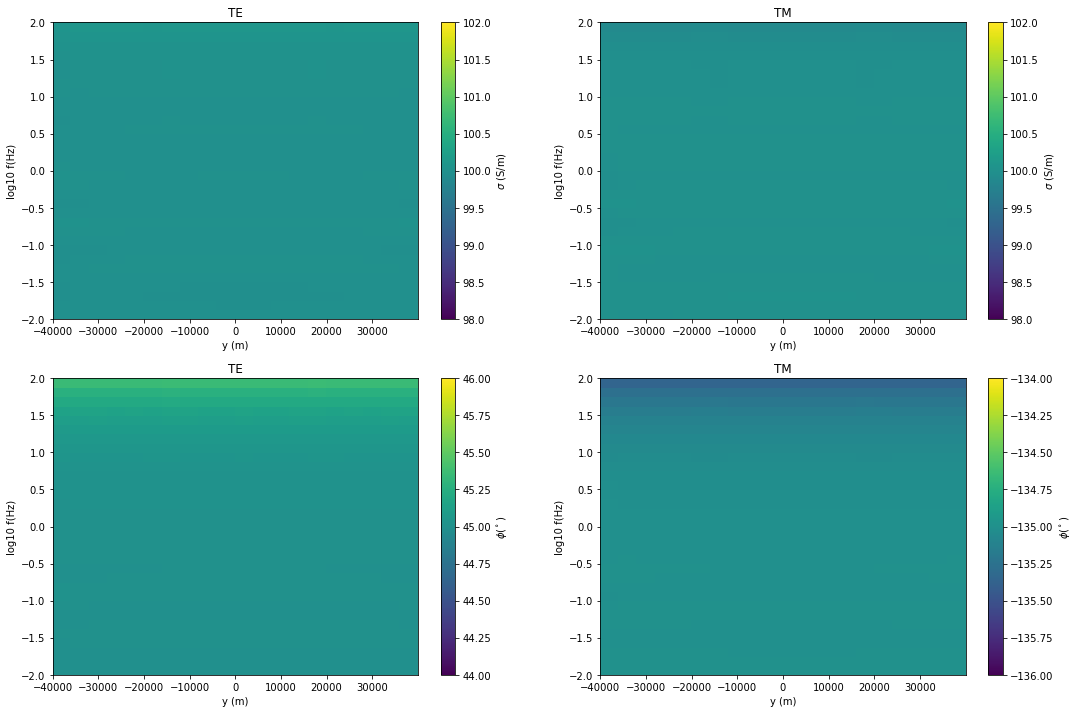

In [16]:
fig, axes = plt.subplots(2, 2)
p = axes[0,0].pcolormesh(r_y, np.log10(frequencies), rho_data[:,:,0], vmin=98, vmax = 102)
fig.colorbar(p, ax=axes[0,0], label=r'$\sigma$ (S/m)')
axes[0,0].set_title('TE'), axes[0,0].set_xlabel('y (m)'), axes[0,0].set_ylabel('log10 f(Hz)')
p = axes[0,1].pcolormesh(r_y, np.log10(frequencies), rho_data[:,:,1], vmin=98, vmax = 102)
fig.colorbar(p, ax=axes[0,1], label=r'$\sigma$ (S/m)')
axes[0,1].set_title('TM'), axes[0,1].set_xlabel('y (m)'), axes[0,1].set_ylabel('log10 f(Hz)')
p = axes[1,0].pcolormesh(r_y, np.log10(frequencies), phi_data[:,:,0], vmin=44, vmax = 46)
fig.colorbar(p, ax=axes[1,0], label=r'$\phi (^\circ)$')
axes[1,0].set_title('TE'), axes[1,0].set_xlabel('y (m)'), axes[1,0].set_ylabel('log10 f(Hz)')
p = axes[1,1].pcolormesh(r_y, np.log10(frequencies), phi_data[:,:,1], vmin=-136, vmax = -134)
fig.colorbar(p, ax=axes[1,1], label=r'$\phi (^\circ)$')
axes[1,1].set_title('TM'), axes[1,1].set_xlabel('y (m)'), axes[1,1].set_ylabel('log10 f(Hz)')
fig.set_size_inches(np.array(fig.get_size_inches()) * 3)

As is anticipated, they look pretty boring, but match analytical values very well, confirming high accuracy. Note also that for the high frequencies wee see slight deviations from the theoretical values (visible in the phase plots). This can be fixed by adding one more refinement around receivers. 